In [ ]:
!pip install yfinance prophet

In [3]:
from main import get_pair_tickers
import pandas as pd
usdt_tickers = get_pair_tickers()
data = pd.read_pickle(f'usdt_data/{usdt_tickers[1]}.pickle').astype(float)
data = data[['open','high','low','close','volume','trades']].dropna()

In [14]:
btcdata = pd.read_pickle(f'usdt_data/BTCUSDT.pickle').astype(float)
btcdata = btcdata[['open','high','low','close','volume','trades']].dropna()

In [6]:
from prophet import Prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
train_end_date = data.index[int(len(data)*.75)]

In [ ]:
#essayer avec toutes les features ou k-acp

In [47]:
df_train = pd.DataFrame()
df_train['ds']=data.index[data.index<train_end_date].copy()
df_train['y']=data['close'][data.index<train_end_date].copy().reset_index(drop=True)
df_train['MA'] = df_train['y'].rolling(window=3).mean().copy().reset_index(drop=True)
df_train = df_train.iloc[2:,:]

df_test= pd.DataFrame()
df_test['ds']=data.index[data.index>train_end_date].copy()
df_test['y']=data['close'][data.index>train_end_date].copy().reset_index(drop=True)
df_test['MA'] = df_test['y'].rolling(window=3).mean().copy().reset_index(drop=True)
df_test = df_test.iloc[2:,:]

In [48]:
model_baseline = Prophet()
model_baseline.fit(df_train)

22:32:39 - cmdstanpy - INFO - Chain [1] start processing
22:33:26 - cmdstanpy - INFO - Chain [1] done processing


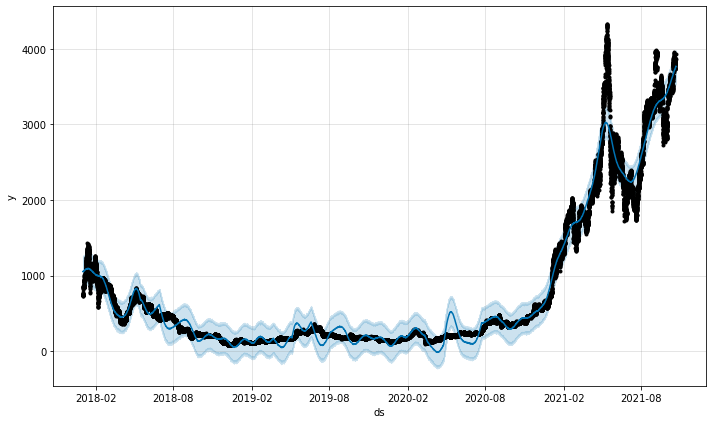

In [49]:
future_baseline = model_baseline.make_future_dataframe(periods=24, freq='H')
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline);

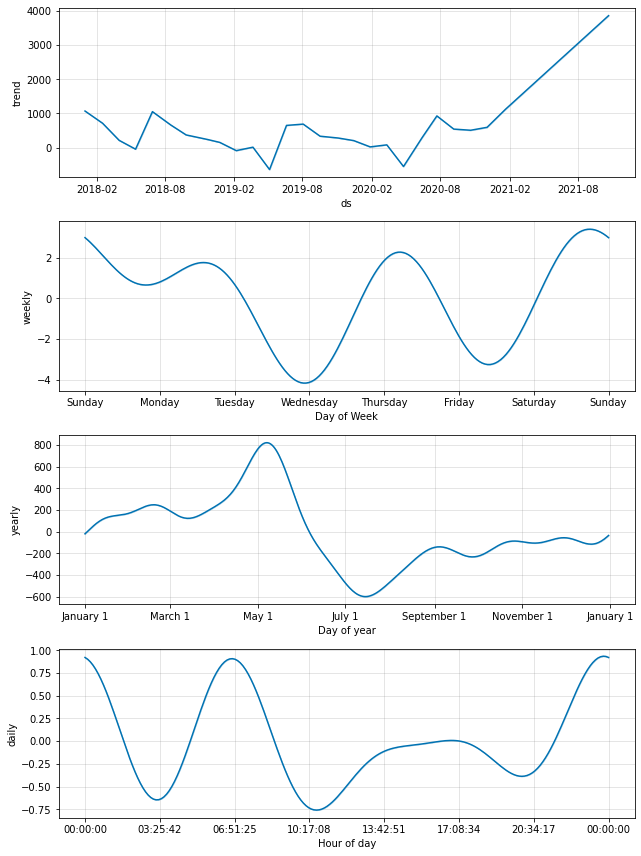

In [50]:
model_baseline.plot_components(forecast_baseline);

In [51]:
performance_baseline = pd.merge(df_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 427.760679633253
The MAPE for the baseline model is 0.10192407119149204


In [70]:
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, changepoint_prior_scale=0.01, seasonality_prior_scale=10)
model_season.fit(df_train)

22:48:07 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing


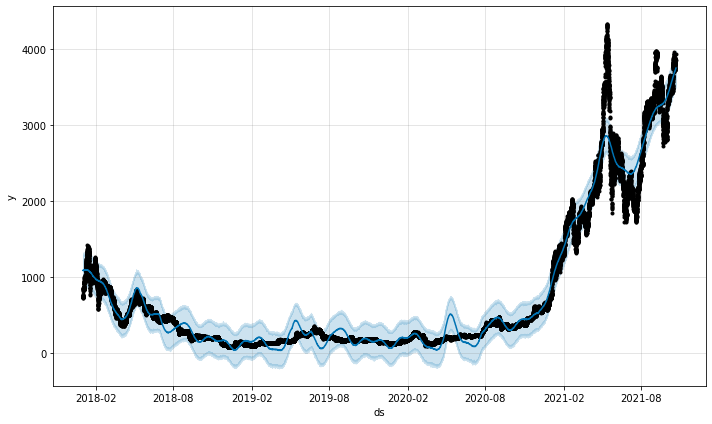

In [71]:
future_season = model_season.make_future_dataframe(periods=24, freq='H')
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season);

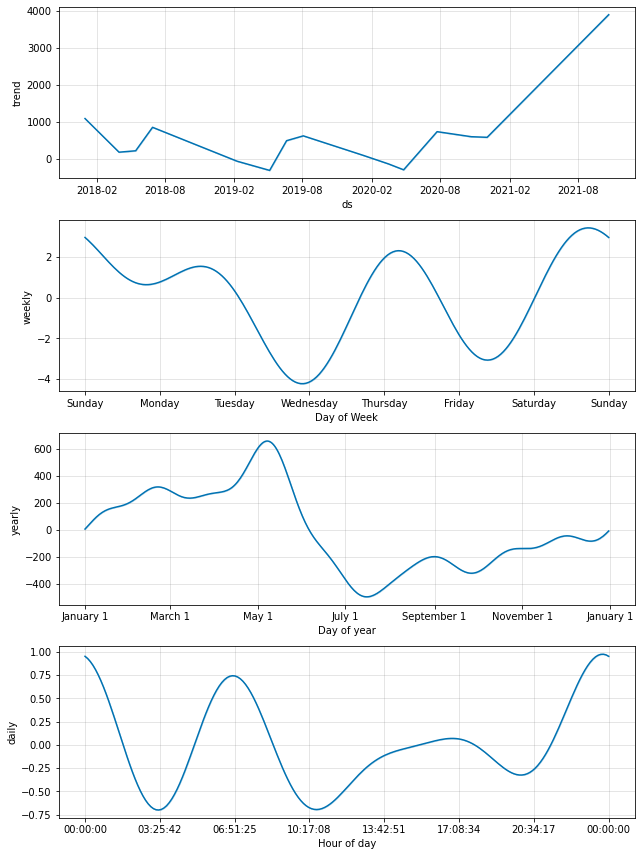

In [72]:
model_season.plot_components(forecast_season);

In [73]:
performance_season = pd.merge(df_test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 445.5954070525415
The MAPE for the seasonality model is 0.10617973915462692


In [61]:
# Add seasonality 
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
# Add regressor
model_multivariate.add_regressor('MA', standardize=False)
# Fit the model on the training dataset
model_multivariate.fit(df_train)

22:40:48 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=16)
# Append the regressor values
future_multivariate = pd.merge(future_multivariate, df_train[['ds', 'MA']], on='ds', how='inner')
# Fill the missing values with the previous value
future_multivariate.tail(10)

,ds,MA
33192,2021-10-20 03:00:00,3849.943333
33193,2021-10-20 04:00:00,3849.566667
33194,2021-10-20 05:00:00,3847.600000
33195,2021-10-20 06:00:00,3845.526667
33196,2021-10-20 07:00:00,3845.840000
33197,2021-10-20 08:00:00,3848.970000
33198,2021-10-20 09:00:00,3859.160000
33199,2021-10-20 10:00:00,3857.556667
33200,2021-10-20 11:00:00,3861.020000
33201,2021-10-20 12:00:00,3882.656667


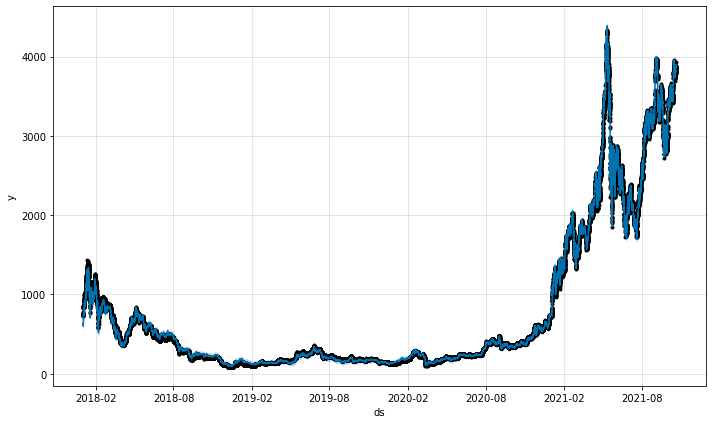

In [79]:
forecast_multivariate = model_multivariate.predict(future_multivariate)
model_multivariate.plot(forecast_multivariate);

In [114]:
performance_multivariate = pd.concat([df_train['y'].reset_index(drop=True),forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)], axis=1)
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the seasonality model is {performance_multivariate_MAE}')
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the seasonality model is {performance_multivariate_MAPE}')

The MAE for the seasonality model is 17.41667172574852
The MAPE for the seasonality model is 0.05009678229683885


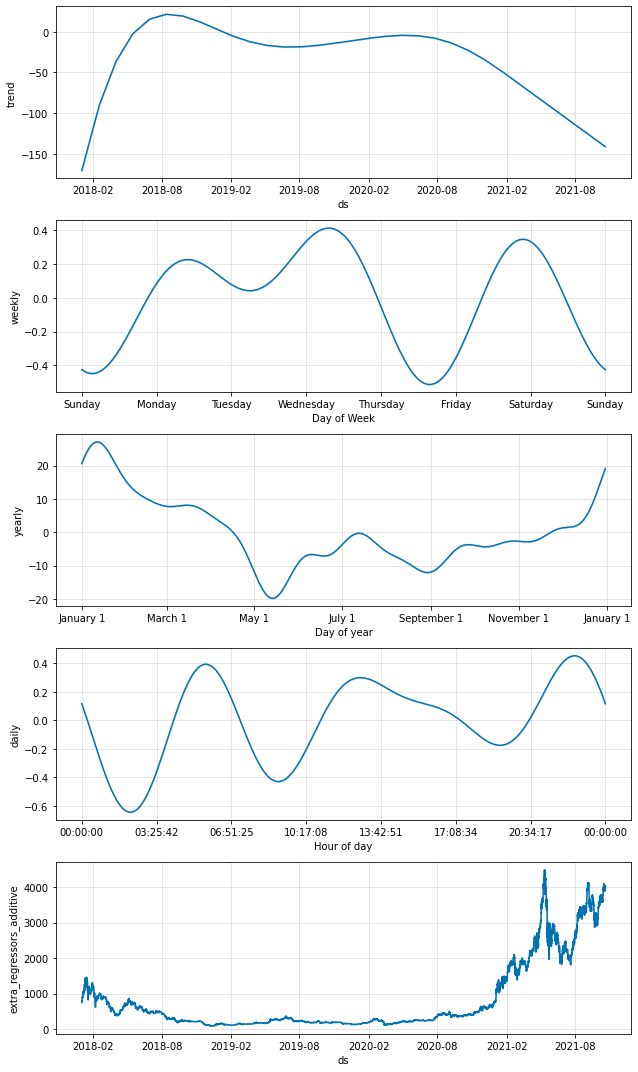

In [99]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [106]:
# Add seasonality 
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')
# Add regressor
model_holiday.add_regressor('MA', standardize=False)
model_holiday.train_holiday_names

In [107]:
# Fit the model on the training dataset
model_holiday.fit(df_train)

23:08:02 - cmdstanpy - INFO - Chain [1] start processing
23:08:32 - cmdstanpy - INFO - Chain [1] done processing


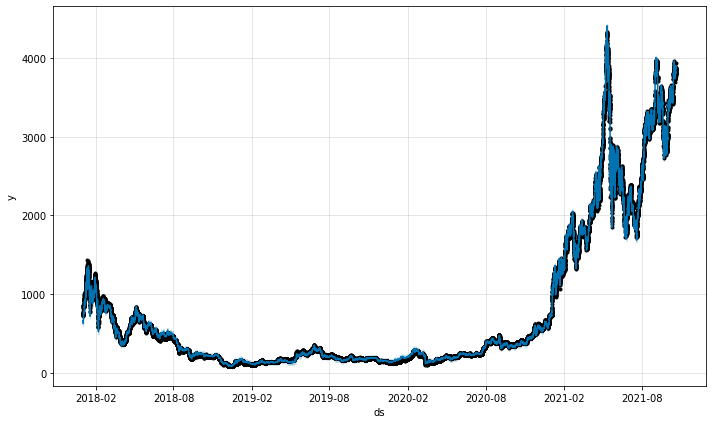

In [108]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)
# Append the regressor values
future_holiday = pd.merge(future_holiday, df_train[['ds', 'MA']], on='ds', how='inner')
# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')
# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)
# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [115]:
performance_holiday = pd.concat([df_train['y'].reset_index(drop=True),forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].reset_index(drop=True)], axis=1)
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the seasonality model is {performance_holiday_MAE}')
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the seasonality model is {performance_holiday_MAPE}')

The MAE for the seasonality model is 16.31778214553784
The MAPE for the seasonality model is 0.04370288676318393


In [116]:
forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01 02:00:00,627.325881,597.459403,654.889347
1,2018-01-01 03:00:00,630.000222,602.068462,658.338528
2,2018-01-01 04:00:00,639.985237,609.962938,666.160099
3,2018-01-01 05:00:00,649.264944,620.883897,677.068132
4,2018-01-01 06:00:00,659.184283,632.385981,687.036544
...,...,...,...,...
33197,2021-10-20 08:00:00,3863.402997,3839.022814,3890.929279
33198,2021-10-20 09:00:00,3873.983263,3846.915344,3901.103771
33199,2021-10-20 10:00:00,3872.419753,3845.517049,3900.687397
33200,2021-10-20 11:00:00,3876.337839,3849.353183,3906.642741


In [117]:
df_train

,ds,y,MA
2,2018-01-01 02:00:00,724.05,723.213333
3,2018-01-01 03:00:00,734.50,725.506667
4,2018-01-01 04:00:00,744.82,734.456667
5,2018-01-01 05:00:00,748.99,742.770000
6,2018-01-01 06:00:00,762.18,751.996667
...,...,...,...
33199,2021-10-20 08:00:00,3850.62,3848.970000
33200,2021-10-20 09:00:00,3868.59,3859.160000
33201,2021-10-20 10:00:00,3853.46,3857.556667
33202,2021-10-20 11:00:00,3861.01,3861.020000


In [122]:
future_holiday = model_holiday.make_future_dataframe(periods=16)
future_holiday = pd.merge(future_holiday, df_train[['ds', 'MA']], on='ds', how='inner')
forecast_holiday = model_holiday.predict(future_holiday)

In [ ]:
forecast_holiday = model_holiday.predict(future_holiday)